Notebook of training neural network to first identify ships in the clean, labeled dataset from here - https://www.kaggle.com/rhammell/ships-in-satellite-imagery

Then use normalization methods and data augmentation to identify ships in Suez canal satellite images taken from the around the time of the Evergreen canal blockage. These were downloaded from planet.com using an educational account.

See the pdf report in this repository for full details of the project.




In [1]:

import numpy as np
import matplotlib.pyplot as plt
import rasterio 
# Libraries to handle the data
import json
from PIL import Image # PIL = Python Image Library
import sys

np.random.seed(16)
#open training data file
file = open('shipsnet.json')
dataset = json.load(file)
file.close()



Some initial data inspection

In [2]:
with open('training_index.txt') as f:
    indices = f.readlines()
    
indices = indices[1:]
for i in range(len(indices)):

    indices[i] = int(indices[i])

indices = np.array(indices)
indices = indices - 1


<class 'dict'>
dict_keys(['data', 'labels', 'locations', 'scene_ids'])
106.65645833333333
<class 'int'>
(4000, 19200)
(4000,)
(80, 80, 3)


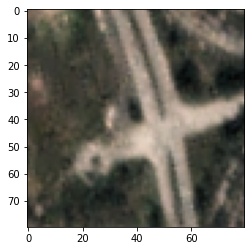

In [3]:
#inspect the data
print(type(dataset))
print(dataset.keys())

#our datapoints of interest will be data and labels, let's inspect further
data = dataset['data']
labels = dataset['labels']

#this tells us our values are 0-255 int
print(np.mean(data[0]))
print(type(data[0][0]))

print(np.shape(data))
print(np.shape(labels))

dataset_length = np.shape(data)[0]
# we can see from the shape of the data that the arrays have already been flattened, as the 19200 length is 80 * 80 * 3
image_width = 80
image_height = 80
channels = 3 #rgb
input_shape = (image_height,image_width,channels)
# convert data to images
images = []

for index in range(dataset_length):
  flat_image = data[index]
  #need to convert to uint8 for image displaying in matplotlib
  image = np.array(flat_image).astype('uint8')
  image = image.reshape(channels,image_width * image_height).T # to transpose
  image = image.reshape(input_shape)
  #now we have 80 x 80 x 3
  images.append(image)

images = np.array(images)

print(np.shape(image))
im = Image.fromarray(image)
plt.imshow(im)
plt.show()

#scale to between 0-1 for analysis need floats
images = images / 255.0

In [4]:
# Splitting the dataset from our indices

labels = np.array(labels)
x_train = images[indices]
y_train = labels[indices]
mask = np.ones(len(labels), np.bool)
mask[indices] = 0
x_test = images[mask]
y_test = labels[mask]
print(np.shape(y_test))

(800,)


Let's build initial model without much regularization, just 3 convolutional layers with fully connected output layers. The Adam gradient descent optimizer is widely seen as the most effective for most neural networks and we will use it here.

In [5]:
import tensorflow as tf
tf.random.set_seed(16)



#building cnn model without dropout

classification_cnn1 = tf.keras.Sequential([
                                          tf.keras.layers.Conv2D(filters = 64,kernel_size = 5,strides = 1, activation = 'relu',padding = 'same', input_shape = input_shape),
                                          tf.keras.layers.MaxPooling2D(pool_size = [2,2],strides = 2),
                                          
                                          tf.keras.layers.Conv2D(filters = 64,kernel_size = 5,strides = 1, activation = 'relu',padding = 'same', input_shape = input_shape),
                                          tf.keras.layers.MaxPooling2D(pool_size = [2,2],strides = 2),
                                          
                                          tf.keras.layers.Conv2D(filters = 64,kernel_size = 5,strides = 1, activation = 'relu',padding = 'same', input_shape = input_shape),
                                          tf.keras.layers.MaxPooling2D(pool_size = [2,2],strides = 2),
                                          
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128,activation = 'relu'),
                                          
                                          tf.keras.layers.Dense(units=1, activation='sigmoid')
])

classification_cnn1.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [6]:
#training model

y_train = np.array(y_train)
y_test = np.array(y_test)
history1 = classification_cnn1.fit(x_train,y_train, 
                                 batch_size = 64,
                                 shuffle = True,
                                 steps_per_epoch = 20, 
                                 epochs = 40,  
                                 validation_data=(x_test,y_test), 
                                 verbose = 1 
                                 )

Epoch 1/40
20/20 [==============================] - 14s 675ms/step - loss: 0.5871 - accuracy: 0.7401 - val_loss: 0.3882 - val_accuracy: 0.8338
Epoch 2/40
20/20 [==============================] - 15s 754ms/step - loss: 0.3859 - accuracy: 0.8558 - val_loss: 0.2557 - val_accuracy: 0.8938
Epoch 3/40
20/20 [==============================] - 15s 748ms/step - loss: 0.2800 - accuracy: 0.8782 - val_loss: 0.2188 - val_accuracy: 0.9125
Epoch 4/40
20/20 [==============================] - 15s 741ms/step - loss: 0.1947 - accuracy: 0.9233 - val_loss: 0.1805 - val_accuracy: 0.9225
Epoch 5/40
20/20 [==============================] - 13s 674ms/step - loss: 0.2024 - accuracy: 0.9059 - val_loss: 0.1730 - val_accuracy: 0.9300
Epoch 6/40
20/20 [==============================] - 13s 666ms/step - loss: 0.1609 - accuracy: 0.9228 - val_loss: 0.1810 - val_accuracy: 0.9325
Epoch 7/40
20/20 [==============================] - 13s 657ms/step - loss: 0.1907 - accuracy: 0.9239 - val_loss: 0.1403 - val_accuracy: 0.9463

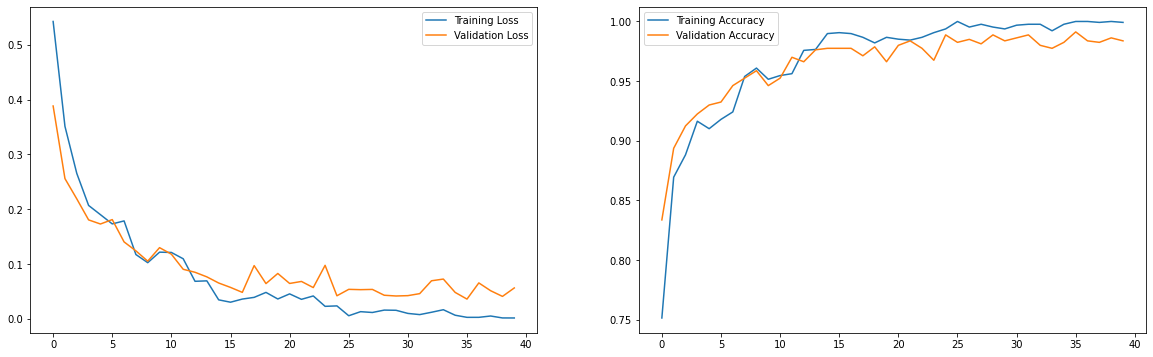

In [7]:
%matplotlib inline
#plot the model training and evaluation for model without dropout
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax1.plot(history1.history['loss'], label='Training Loss')
ax1.plot(history1.history['val_loss'], label='Validation Loss')
ax1.legend()
ax2.plot(history1.history['accuracy'], label='Training Accuracy')
ax2.plot(history1.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()

On a test image, we see here that it predicts a ship correctly with 99.9% probability

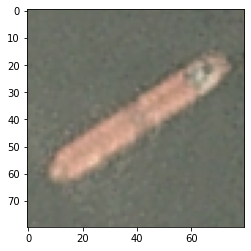

array([[0.9999871]], dtype=float32)

In [8]:

test_image = np.expand_dims( images[166], axis = 0)
im = np.squeeze(test_image)
im = Image.fromarray((im * 255).astype(np.uint8))

plt.imshow(im)
plt.show()
y_pred = classification_cnn1.predict( test_image )
y_pred


We will now inspect the suez data and see how well our model works on identifying ships there

(4691, 4752)
64.11282585022637


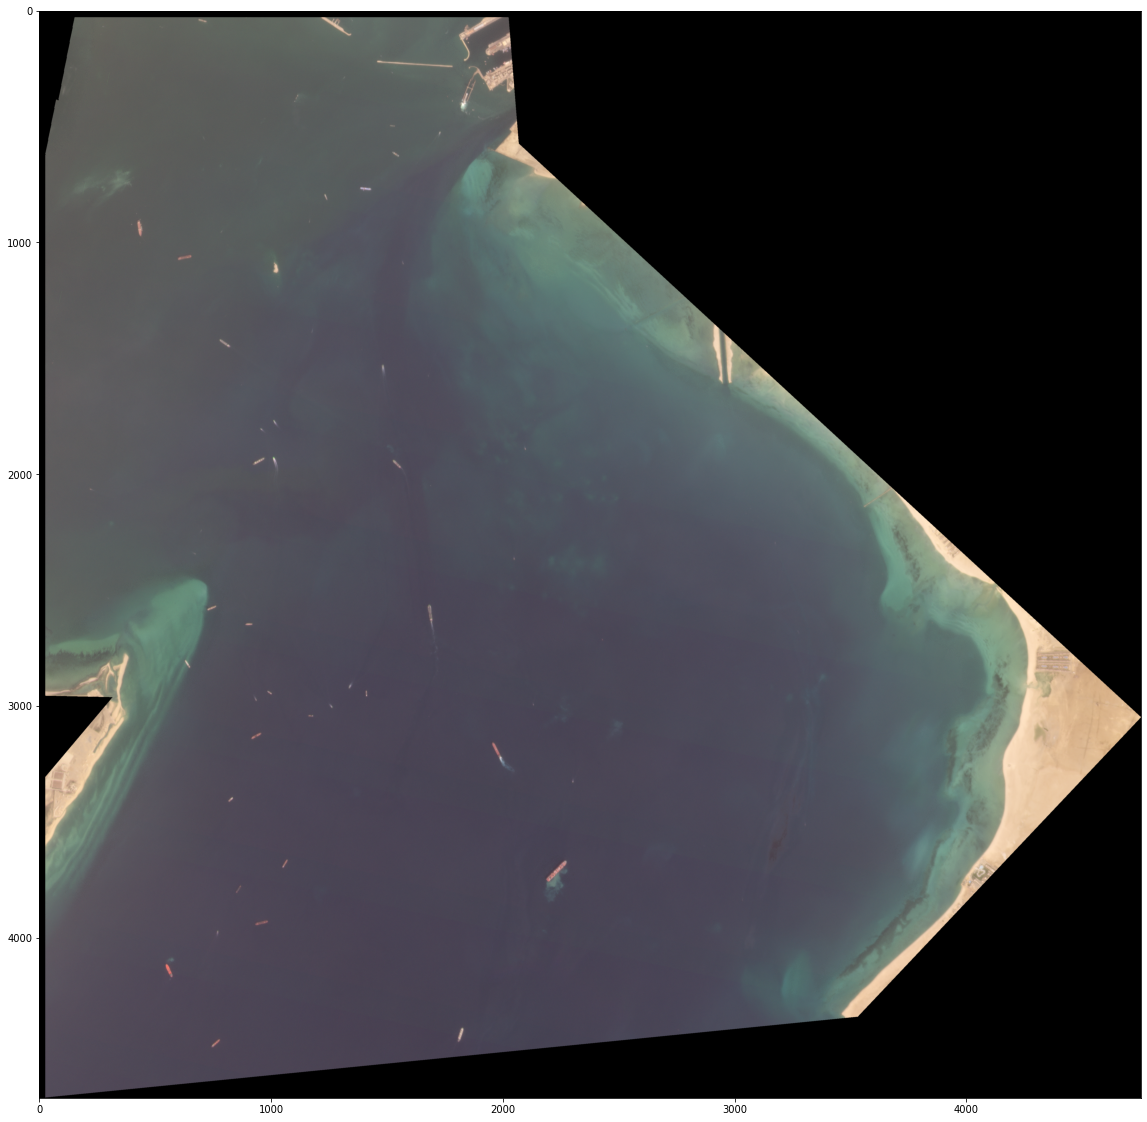

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
fp = 'images/visual_color_corrected.tif'

sat_data = rasterio.open(fp)
print(np.shape(sat_data))




color = np.dstack(sat_data.read([1,2,3]))
print(np.mean(color))

plt.figure(figsize=(20,20))
fig = plt.imshow(color)

plt.show()




Let's try isolating some of the ships and testing our model on that

Here we have a list of ships we have identified, and we see how our model classifies these

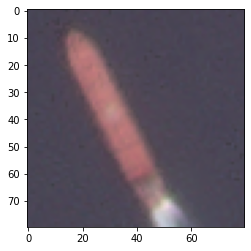

[[1.0594188e-07]]


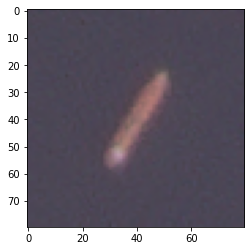

[[0.03735888]]


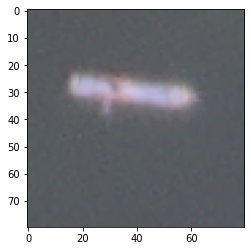

[[6.698697e-05]]


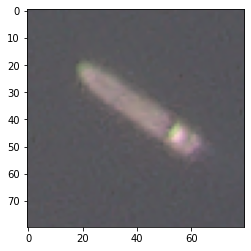

[[0.99478716]]


In [10]:
image_size = 80
y_x_list = [[3150,1940],[3640,1020],[740,1370],[1400,760]]
pixel_size = 80

for coords in y_x_list:
  image = color[coords[0]:coords[0]+image_size,coords[1]:coords[1]+image_size,:]
  
  fig = plt.imshow(image)
  plt.show()
  image = image / 255.0
  chip_p = np.expand_dims(image, axis = 0)
  pred = classification_cnn1.predict(chip_p)
  print(pred)


As seen above, it only classifies the last ship as a ship, so we need a new approach

Let's try a new model with more regularization techniques, which should avoid overfitting to the original dataset, as well as some image augmentation to again improve how well the model can generalize to new data.

In [11]:
#classifier with more regularization techniques, so will use dropout and retrain on original dataset, and will also train the same model on augmented dataset

classification_cnn2 = tf.keras.Sequential([
                                          tf.keras.layers.Conv2D(filters = 64,kernel_size = 3,strides = 1, activation = 'relu',padding = 'same', input_shape = input_shape),
                                          
                                          tf.keras.layers.MaxPooling2D(pool_size = [2,2],strides = 2),
                                          tf.keras.layers.Dropout(0.2),
                                           
                                          tf.keras.layers.Conv2D(filters = 64,kernel_size = 3,strides = 1, activation = 'relu',padding = 'same', input_shape = input_shape),
                                         
                                          tf.keras.layers.MaxPooling2D(pool_size = [2,2],strides = 2),
                                          tf.keras.layers.Dropout(0.2),
                                           
                                          tf.keras.layers.Conv2D(filters = 64,kernel_size = 3,strides = 1, activation = 'relu',padding = 'same', input_shape = input_shape),
                                         
                                          tf.keras.layers.MaxPooling2D(pool_size = [2,2],strides = 2),
                                          tf.keras.layers.Dropout(0.2),

                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(32,activation = 'relu'),
                                          tf.keras.layers.Dropout(0.4),
                                          tf.keras.layers.Dense(units=1, activation='sigmoid')
])

classification_cnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

Idea for data augmentation in order to be able to find partial ships in the suez data is to shift the ships over so that they are only partially visiable, and by using the augmentation "nearest", ships in the ocean may still look like they are in the ocean.

In [12]:
#need some data augmentation to capture partial ships potentially
#augment only the positive class
print(y_train)
positives = labels == 1
negatives = labels == 0

positive_x = images[positives]
positive_y = labels[positives]



image_augmentor_pos = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True,vertical_flip = True,fill_mode = 'wrap',rotation_range=180)
image_augmentor_pos.fit(positive_x)
augmented_train = image_augmentor_pos.flow(x=positive_x,y=positive_y,batch_size = len(images) , shuffle = False)
aug_x, aug_y = augmented_train[0]
print(aug_x.shape)
print(aug_y.shape)

[0 0 1 ... 0 0 0]
(1000, 80, 80, 3)
(1000,)


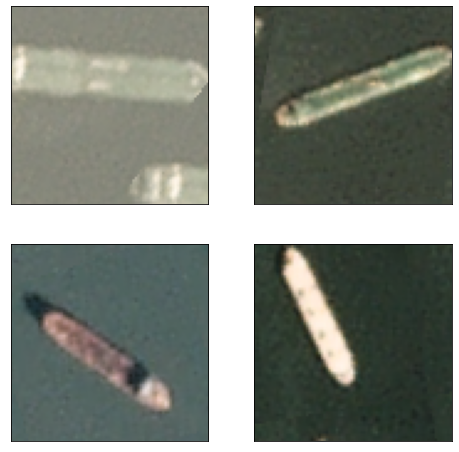

In [13]:
#Visualize augmented 8x8 images
def display(x,row,col):
  num_images = row*col 
  fig,axe = plt.subplots(row,col,figsize =(8,8))

  for i in range(row):
    for j in range(col):
      axe[i][j].imshow(x[np.random.randint(0,500),:])
      axe[i][j].set_xticks([])
      axe[i][j].set_yticks([])

  plt.show()      

row = 2
col = 2
display(aug_x,row,col)

In [14]:
#combine original and augemented datasets for training

aug_original_x_train = np.vstack((images,aug_x))
np.shape(aug_original_x_train)
aug_original_y_train = np.concatenate((labels,aug_y))
np.shape(aug_original_y_train)



(5000,)

In [15]:
history_cnn_3 = classification_cnn2.fit(aug_original_x_train, aug_original_y_train, batch_size = 64,  
                                 shuffle = True,
                                 epochs = 90,
                                 validation_split = 0.1,   
                                 verbose = 1 
                                 )

Epoch 1/90
71/71 [==============================] - 27s 376ms/step - loss: 0.6247 - accuracy: 0.6501 - val_loss: 1.5818 - val_accuracy: 0.1900
Epoch 2/90
71/71 [==============================] - 26s 371ms/step - loss: 0.4878 - accuracy: 0.8107 - val_loss: 1.1290 - val_accuracy: 0.3060
Epoch 3/90
71/71 [==============================] - 26s 365ms/step - loss: 0.4147 - accuracy: 0.8321 - val_loss: 1.1366 - val_accuracy: 0.4580
Epoch 4/90
71/71 [==============================] - 26s 369ms/step - loss: 0.3950 - accuracy: 0.8674 - val_loss: 0.8563 - val_accuracy: 0.7300
Epoch 5/90
71/71 [==============================] - 25s 357ms/step - loss: 0.3812 - accuracy: 0.8597 - val_loss: 0.8484 - val_accuracy: 0.6160
Epoch 6/90
71/71 [==============================] - 25s 348ms/step - loss: 0.3723 - accuracy: 0.8717 - val_loss: 1.0847 - val_accuracy: 0.5840
Epoch 7/90
71/71 [==============================] - 25s 353ms/step - loss: 0.3596 - accuracy: 0.8688 - val_loss: 0.9194 - val_accuracy: 0.6460

Epoch 58/90
71/71 [==============================] - 24s 339ms/step - loss: 0.0575 - accuracy: 0.9833 - val_loss: 0.8240 - val_accuracy: 0.8420
Epoch 59/90
71/71 [==============================] - 25s 350ms/step - loss: 0.0491 - accuracy: 0.9840 - val_loss: 0.9659 - val_accuracy: 0.7780
Epoch 60/90
71/71 [==============================] - 25s 348ms/step - loss: 0.0518 - accuracy: 0.9832 - val_loss: 0.9198 - val_accuracy: 0.8200
Epoch 61/90
71/71 [==============================] - 24s 343ms/step - loss: 0.0491 - accuracy: 0.9857 - val_loss: 1.1831 - val_accuracy: 0.8020
Epoch 62/90
71/71 [==============================] - 24s 339ms/step - loss: 0.0471 - accuracy: 0.9869 - val_loss: 0.5844 - val_accuracy: 0.8560
Epoch 63/90
71/71 [==============================] - 24s 341ms/step - loss: 0.0414 - accuracy: 0.9891 - val_loss: 0.8094 - val_accuracy: 0.8220
Epoch 64/90
71/71 [==============================] - 24s 340ms/step - loss: 0.0402 - accuracy: 0.9881 - val_loss: 0.5599 - val_accuracy:

Text(0.5, 1.0, 'Training Accuracy Improvement')

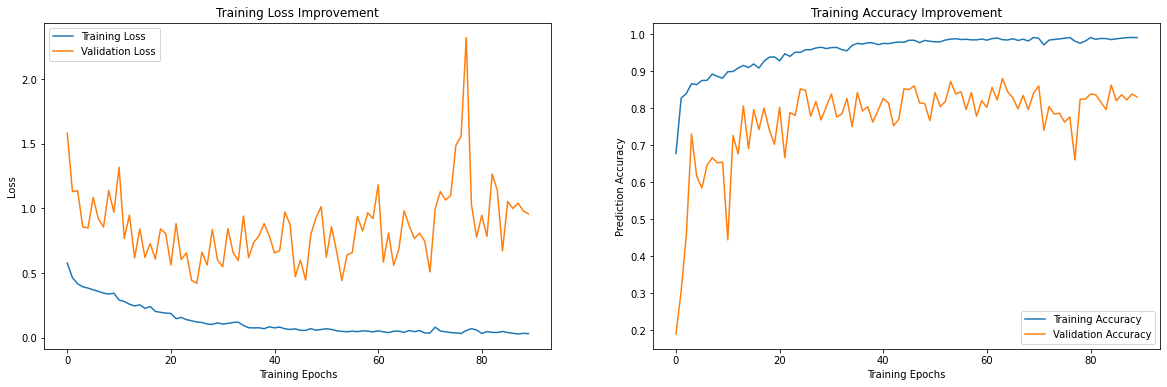

In [16]:
%matplotlib inline
#plot the model training and evaluation for model without dropout
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax1.plot(history_cnn_3.history['loss'], label='Training Loss')
ax1.plot(history_cnn_3.history['val_loss'], label='Validation Loss')
ax1.legend()
ax2.plot(history_cnn_3.history['accuracy'], label='Training Accuracy')
ax2.plot(history_cnn_3.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
# Set common labels
ax1.set_xlabel('Training Epochs')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Training Epochs')
ax2.set_ylabel('Prediction Accuracy')

ax1.set_title('Training Loss Improvement')
ax2.set_title('Training Accuracy Improvement')

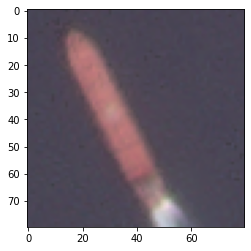

[[0.08305198]]


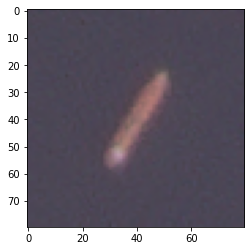

[[0.9899064]]


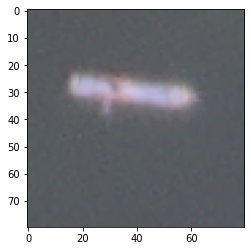

[[0.9850161]]


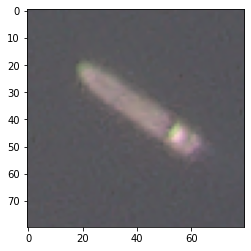

[[0.84919167]]


In [17]:
for coords in y_x_list:
  image = color[coords[0]:coords[0]+image_size,coords[1]:coords[1]+image_size,:]
  
  fig = plt.imshow(image)
  plt.show()
  image = image / 255.0
  chip_p = np.expand_dims(image, axis = 0)
  pred = classification_cnn2.predict(chip_p)
  print(pred)

Now with much more promising results on the subset of identified images, we create a method that takes a satellite image as an input, runs through 80x80 frames of the image, and outputs a labelled satellite image with the predicted ships identified with a red square.

In [18]:
import math
import cv2

def output_predicted_image(sat_data):
    color = np.dstack(sat_data.read([1,2,3]))
    
    min_distance = 80
    image_size = 80
    stride = 20
    height_chips = math.floor(np.shape(color)[0]/(stride))
    width_chips = math.floor(np.shape(color)[1]/(stride))

    counts = 0
    ship_counts = 0  
    
    positive_coords = []
    for h in range(height_chips):
      for w in range(width_chips):
        counts+=1
        y_lim = [stride*h,image_size+(stride*h)]
        x_lim = [stride*w,image_size+(stride*w)]
        chip = color[y_lim[0]:y_lim[1],x_lim[0]:x_lim[1],:]
        if np.shape(chip)!=(80,80,3):
          continue

        chip_p = np.expand_dims(chip, axis = 0)
        chip_p = chip_p / 255.0

        #determine how many black pixels there are, if there are too many, it is likely a border image which we want to exclude
        black_pixels = np.all(chip == [0, 0, 0], axis=-1)
        black_count = np.count_nonzero(black_pixels)
        if black_count > 160:
          continue
        pred = classification_cnn2.predict( chip_p )
        #play with % threshold for yes classification
        if pred > 0.5:
          #check if it is a new prediction

          #coords are y_lin then x_lim
          positive_coords.append([[np.mean(y_lim)],[np.mean(x_lim)]])



    print(counts)

    min_distance = 80
    unique_counts = np.array([[positive_coords[0][0][0],positive_coords[0][1][0]]])

    for coord in positive_coords:
      #calculate distance vector
      coords = np.array([coord[0][0],coord[1][0]])
      shifted_coords = unique_counts - coords
      distances = np.linalg.norm(shifted_coords,axis = 1)
      if np.min(distances) > min_distance:
        unique_counts = np.vstack((unique_counts,coords))
    print(len(unique_counts))
    
    
    adjusted_color = np.copy(color)

    for coords in unique_counts:
      y_spot = int(coords[0])
      x_spot = int(coords[1])


      y_range = np.arange((y_spot-15),(y_spot+15))
      x_range = np.arange((x_spot-15),(x_spot+15))

      for x in x_range:
        for y in y_range:

          adjusted_color[y,x,0] = 255
          adjusted_color[y,x,1] += 0
          adjusted_color[y,x,2] += 0


    print(np.shape(adjusted_color))
    plt.figure(figsize=(20,20))
    fig = plt.imshow(adjusted_color)

    plt.show()
    return

55458
30
(4691, 4752, 3)


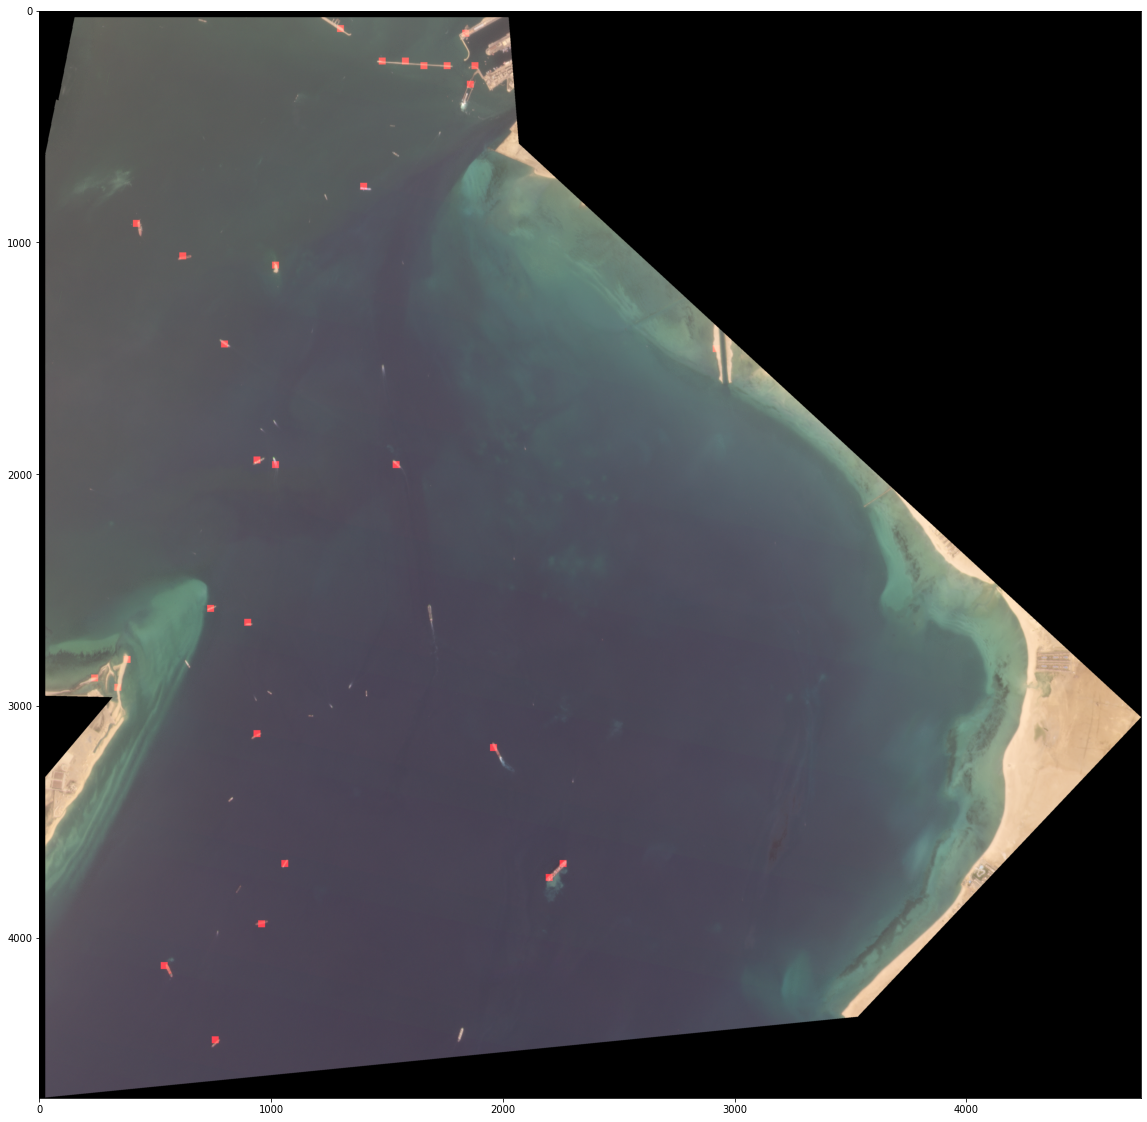

In [19]:
fp = 'images/visual_color_corrected.tif'

sat_data = rasterio.open(fp)
output_predicted_image(sat_data)


55458
28
(4691, 4752, 3)


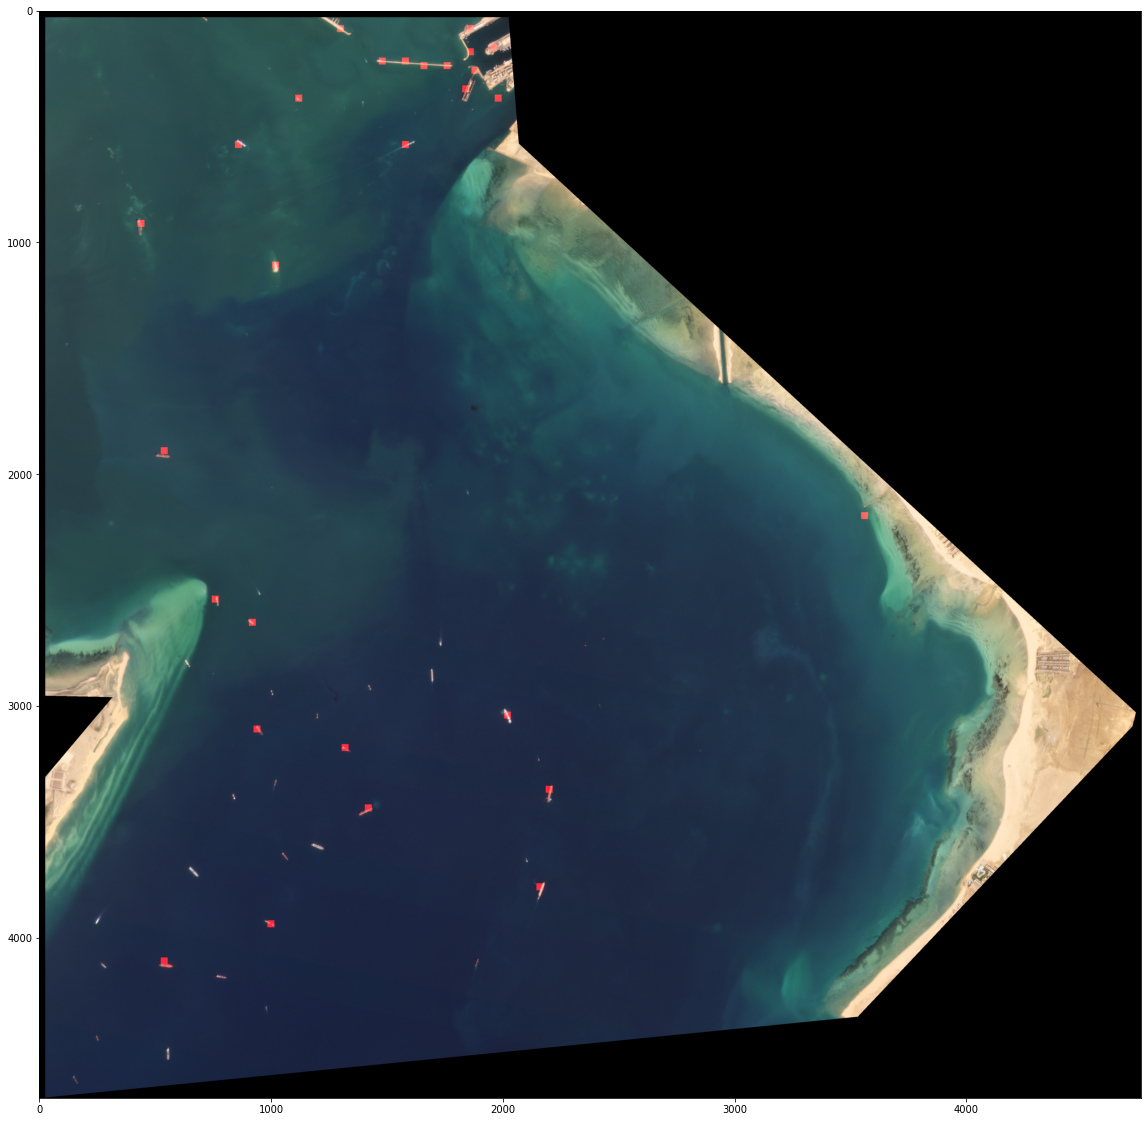

In [20]:
fp = 'images/march_17_suez.tif'

sat_data = rasterio.open(fp)

output_predicted_image(sat_data)


55458
79
(4691, 4752, 3)


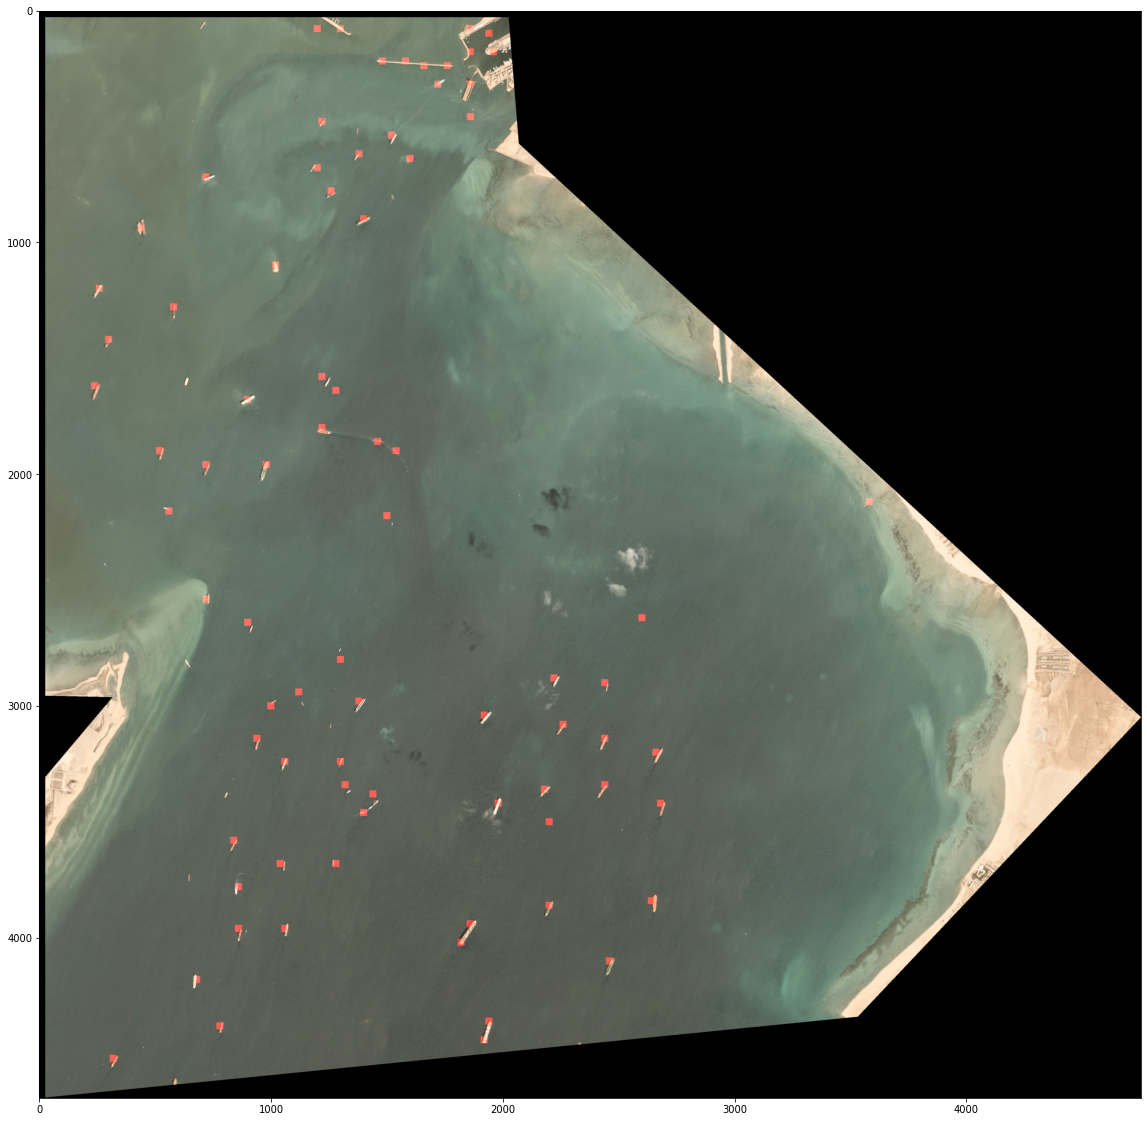

In [21]:
fp = 'images/march_29_suez.tif'

sat_data = rasterio.open(fp)

output_predicted_image(sat_data)

55458
42
(4691, 4752, 3)


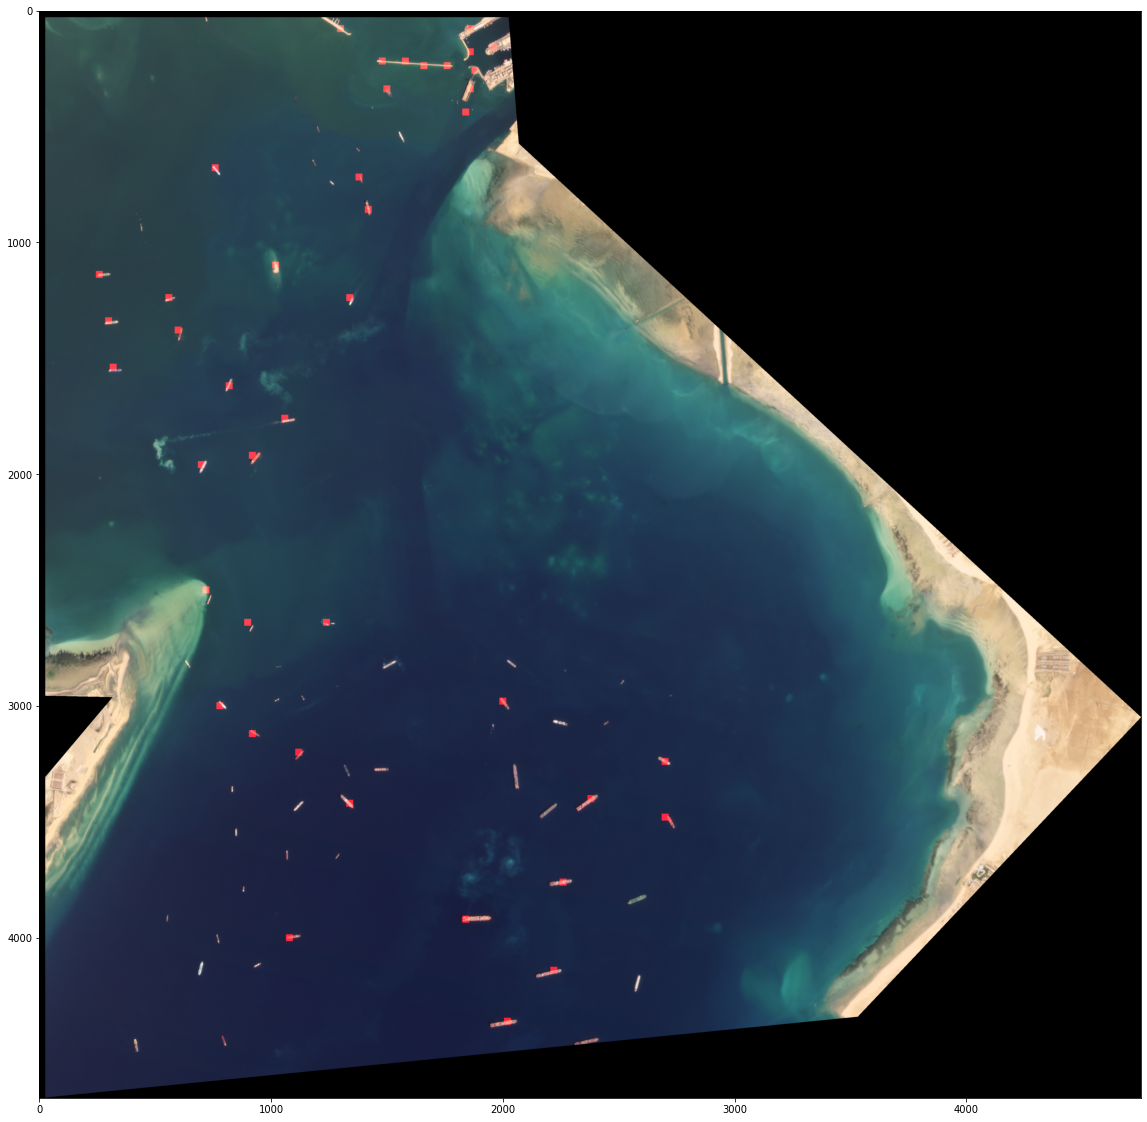

In [22]:
fp = 'images/april_4_suez.tif'

sat_data = rasterio.open(fp)

output_predicted_image(sat_data)

55458
29
(4691, 4752, 3)


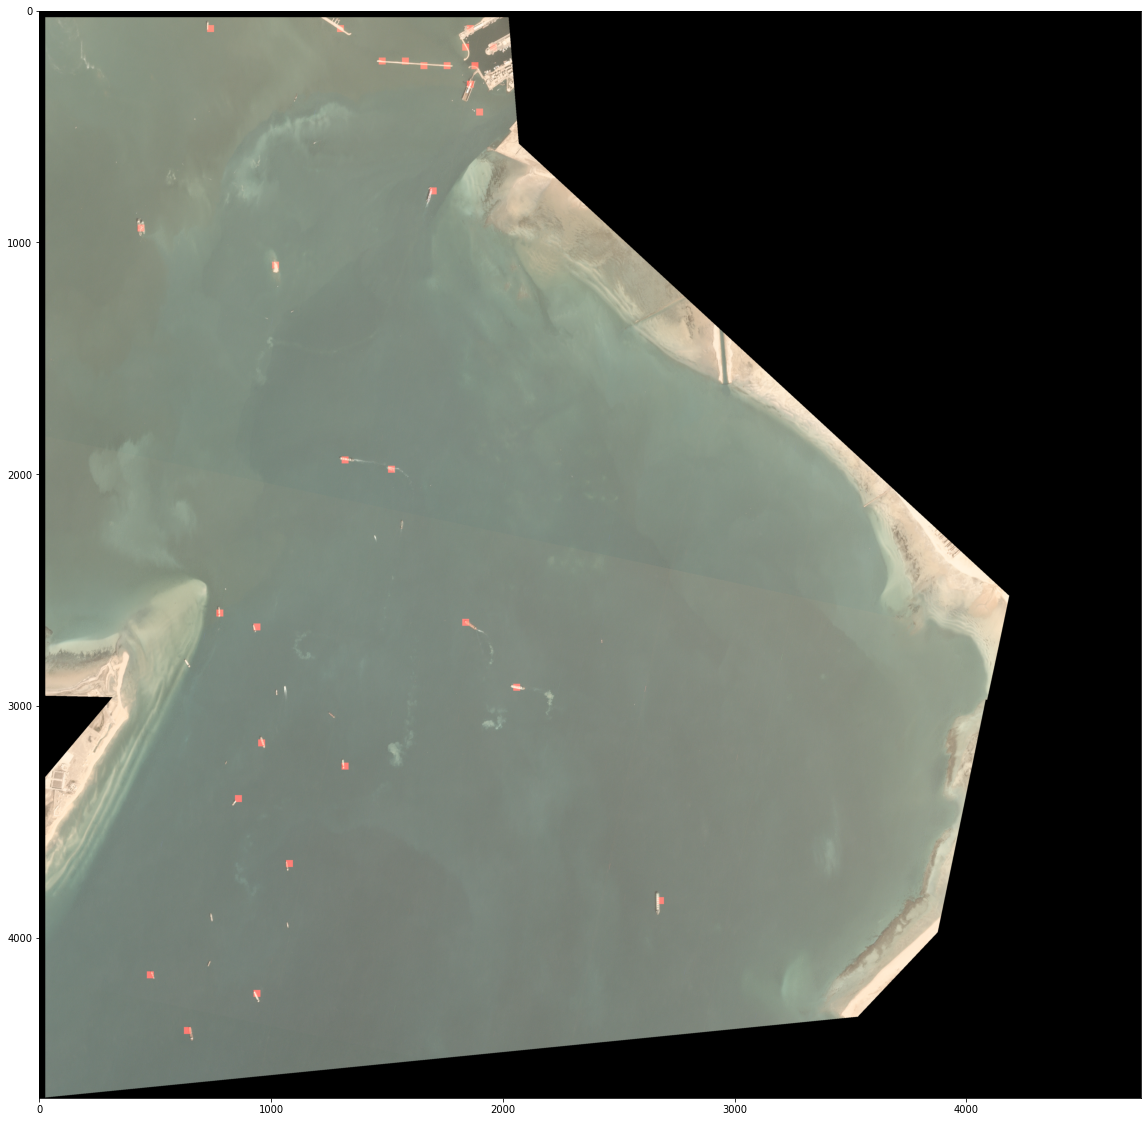

In [23]:
fp = 'images/feb_21_suez.tif'

sat_data = rasterio.open(fp)

output_predicted_image(sat_data)